In [1]:
### Pacotes para abrir arquivos que estão em pastas:
import os
import glob

### Pacotes para arrumar os dados:
# import xarray as xr
import math
import numpy as np
import pandas as pd
from datetime import datetime

### Pacotes para plotar os dados:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import markers
%matplotlib inline

### Pacotes para fazer clusterização e PCA:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Pacotes que lidam com mensagens de erros:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pasta = '/mnt/HD_500GB_WD/00_Doutorado/Codigos_Notebooks_Medias_Resample/Dataframes_Media1m/'
# pasta = '/media/andre/SAMSUNG/03_HD_500GB_WD/00_Doutorado/Codigos_Notebooks_Medias_Resample/Dataframes_Media1m/'

### Abrindo os .pkl com medias 1min:
### Propriedades ópticas:
# aod = pd.read_pickle(pasta+'AOD_AERONET_processado.pkl')
# aod2 = pd.read_pickle(pasta+'mfrsraod1michM1_aerosol_optical_depth_filter2_df_T_dias_raw_1m.pkl')
# abs_550_1 = pd.read_pickle(pasta+'1ogrenM1_Ba_G_Dry_1um_PSAP3W_1_df_T_dias_raw_1m.pkl')
# Bbs_550_1 = pd.read_pickle(pasta+'1ogrenM1_Bbs_G_Dry_1um_Neph3W_1_df_T_dias_raw_1m.pkl')
Bs_550_1 = pd.read_pickle(pasta+'1ogrenM1_Bs_G_Dry_1um_Neph3W_1_df_T_dias_raw_1m.pkl')

### Concentrações volumétricas:
org = pd.read_pickle(pasta+'acsmS1_total_organics_df_T_dias_raw_1m.pkl')
ccn = pd.read_pickle(pasta+'ccn1colM1_b1_N_CCN_df_T_dias_raw_1m.pkl')
o3aero = pd.read_pickle(pasta+'Ozone_AERONET_processado.pkl')

In [3]:
### Listando os datasets e seus nomes, labels e unidades, respectivamente:
# datasets = [Bs_550_1, aod, aod2, org, ccn, o3filt, o3aero]
# nomes = ['Bs_550_1', 'AOD', 'AOD', 'org', 'ccn', 'o3filt', 'o3aero']
# labels = [u'$\\sigma$$_s$$_c$$_t$', 'AOD', 'AOD', 'Total Organics', 'CCN', 'O$_{3}$', 'O$_{3}$']

datasets = [Bs_550_1, org, ccn, o3aero]
nomes = ['Bs_550_1', 'org', 'ccn', 'o3aero']
labels = [u'$\\beta$$_e$$_s$$_p$$_.$', 'Org.', 'CCN', 'O$_{3}$']
unities = ['Mm^(-1)', ]

In [4]:
### Função para padronizar o formato do índice (minutos) e das datas nas colunas (padrão: 'DD/MM/AAAA'):
def padroniza_datas(df):
    mins = np.arange(0, 1440, 1)
    datas = list(df.columns)
    datas_arrumadas = []
    for dia in datas:
        if len(dia)==10:
            datas_arrumadas.append(dia)
        elif len(dia)==8:
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]=='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]!='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
    df.columns = datas_arrumadas
    df.index = mins
    df.index.name = "tempo"
    df.columns.name = "dias"
    
### Chamando a função padroniza_datas:
for ds, nome in zip(datasets, nomes):
    padroniza_datas(ds)

In [5]:
### Função que constrói o dataframe com as datas do GoAmazon (01/01/14 a 31/12/15) cheio de NaN's. Depois disso
### insere os dias de 2014 e de 2015 faltantes nos dataframes dos dados:
freq = 1440

def completa_dias_goamazon(df):
    days = pd.date_range(start="2014-01-01", end='2015-12-31',freq='D').strftime('%d/%m/%Y')
    mins = np.arange(0, freq, 1)
    df_nans = pd.DataFrame(columns=days, index=mins)    
    booleanos = []
    for dia in list(df_nans.columns):
        booleanos.append(dia in list(df.columns))
    for i in range(len(booleanos)):
        if booleanos[i] == True:     # Há dados neste dia
            pass
        elif booleanos[i] == False:  # Não há dados neste dia
            df.insert(i, column=df_nans.columns[i], value=df_nans.T.iloc[i].values)
            
### Chamando a função completa_dias_goamazon:
for ds, nome in zip(datasets, nomes):
    completa_dias_goamazon(ds)
    if len(ds.T) != (365*2):
        print('Houve algum erro, pois a quantidade total de dias é {0}'.format(len(ds.T)))

In [6]:
### Separando os datasets para os anos de 2014 e 2015:
colunas14, colunas15 = [], []
for col in datasets[0].columns:
    if str(col).split('/')[-1] == '2014':
        colunas14.append(str(col))
    else:
        colunas15.append(str(col))
datasets14 = [datasets[0][colunas14], datasets[1][colunas14], datasets[2][colunas14], datasets[3][colunas14]]

In [7]:
### Construindo uma lista de dataframes, onde cada um é um dataframe.describe() correspondente a um dataset:
stats = [datasets[n].describe() for n in range(len(datasets))]

In [8]:
### Função que constrói o dataframe com as datas do GoAmazon (01/01/14 a 31/12/15) cheio de NaN's. Depois disso
### insere os dias de 2014 e de 2015 faltantes nos dataframes das estatísticas:
def completa_dias_goamazon_describe(df):
    days = pd.date_range(start="2014-01-01", end='2015-12-31',freq='D').strftime('%d/%m/%Y')
    mins = np.arange(0, 8, 1)
    df_nans = pd.DataFrame(columns=days, index=mins)    
    booleanos = []
    for dia in list(df_nans.columns):
        booleanos.append(dia in list(df.columns))
    for i in range(len(booleanos)):
        if booleanos[i] == True:     # Há dados neste dia
            pass
        elif booleanos[i] == False:  # Não há dados neste dia
            df.insert(i, column=df_nans.columns[i], value=df_nans.T.iloc[i].values)
            
### Chamando a função completa_dias_goamazon_describe:
for described in stats:
    completa_dias_goamazon_describe(described)

In [9]:
### Separando os datasets (com as estatísticas) para os anos de 2014 e 2015:
colunas14, colunas15 = [], []
for col in datasets[0].columns:
    if str(col).split('/')[-1] == '2014':
        colunas14.append(str(col))
    else:
        colunas15.append(str(col))
stats14 = [stats[0][colunas14], stats[1][colunas14], stats[2][colunas14], stats[3][colunas14]]

In [10]:
### Puxando as strings dos dias limpos achados pelo notebook 
### "Series_temporais_medias_diarias_definirperiodos-Copy2":
pasta_dias_estacoes = '/mnt/HD_500GB_WD/historia2/Analises_Aerossois/'

l14 = pd.read_pickle(pasta_dias_estacoes+'diaslimpa14.pkl')
# p14 = pd.read_pickle(pasta_dias_estacoes+'diaspoluida14.pkl')

In [11]:
### Subdividindo os datasets de acordo com o período diurno:
periodo_diurno = [359, 1080]  ## 06:00 às 18:00
datasets14limpodiurno = []
for i in range(len(datasets[:-1])):
    datasets14limpodiurno.append(datasets14[i][l14.columns].iloc[periodo_diurno[0]:periodo_diurno[1]])

In [12]:
### Função que lê as colunas do dataframe df e remove aquelas que só possuem NaN:
def corta_colunas_inteiras_com_nan(df):
    for col in df:
        if df[col].isnull().sum().sum() == len(df[col]):
            df.drop(columns=col, inplace=True)
        else:
            pass
        
### Função que substitui todos os valores menores que zero por zero:
def negativos_para_zero(df):
    df.mask((df < 0.0), 0.0, inplace=True)
    
### Função que substitui todos os valores menores que zero por NaN:
def negativos_para_nan(df):
    df.mask((df < 0.0), np.nan, inplace=True)
        
### Função que lê as colunas do dataframe df e substitui os NaN pela mediana dos valores daquela coluna:
def nan_to_median(df):
    for col in df:
        df[col].fillna(value = df[col].median(), inplace=True)

### Função que lê as colunas do dataframe df e conta a porcentagem de dados NaN. Se essa porcentagem for
### maior ou igual a "porcentagem" que eu escolhi, a coluna é apagada. Caso contrario os NaN são substituídos
### pela mediana dos valores daquela coluna:
def nan_to_median_com_condicao(df, porcentagem):
    for col in df:
        nan_perc = (df[col].isnull().sum()/len(df[col]))*100
        if nan_perc >= porcentagem:
            df.drop(columns=col, inplace=True)
        elif nan_perc < porcentagem:
            df[col].fillna(value = df[col].median(), inplace=True)

In [13]:
### Para todos os datasets14limpodiurno (ozônio está fora!), aplicando as funções desejadas:
for ds in datasets14limpodiurno:
    corta_colunas_inteiras_com_nan(ds)
#     negativos_para_zero(ds)
    negativos_para_nan(ds)
    nan_to_median(ds)
#     nan_to_median_com_condicao(ds, 75.0)

In [14]:
### Função que constrói um set (para cada dataframe) contendo os nomes não duplicados das colunas do df. Depois
### disso usa esses sets para achar a intersecção dos dias entre todos os df. Depois organizando a intersecção 
### em ordem crescente de datas. OBS: O objeto set é utilizado para fazer intersecção "&" ou 
### "set.intersection(*lista_de_sets)" de conjuntos matemáticos
def sets_interseccao(lista_ds):
    sets = []
    for ds in lista_ds:
        c = set(ds.columns)
        sets.append(c)
    colunas_intersec = list(set.intersection(*sets))
    colunas_intersec.sort(key = lambda data: datetime.strptime(data, '%d/%m/%Y'))
    return colunas_intersec

In [15]:
### Aplicando a função que retorna uma lista com as datas em comum já em ordem crescente:
colunas_interseccao = sets_interseccao(datasets14limpodiurno)

### Criando uma lista com os datasets todos sem NaN e com as colunas de intersecção comum a todos: 
datasets_interseccao = []
for ds in datasets14limpodiurno:
    datasets_interseccao.append(ds[colunas_interseccao])

In [16]:
### Para o dataframe de cada variavel, calcular a mediana diárias diurna (mediana de cada coluna), colocar essas
### medianas numa lista e depois adicionar cada lista de medianas à lista final "medianas": 
medianas = []
for n in range(len(nomes[:-1])):
    medianas.append([])
    for col in datasets_interseccao[n]:
        medianas[n].append(datasets_interseccao[n][col].median())
        
### Construindo um dicionário onde as chaves são os nomes das variáveis e os valores são as listas com as
### medianas diárias diurnas:
dic = {}
for i in range(len(nomes[:-1])):
    dic[nomes[i]] = medianas[i]
    
### Construindo uma lista com o ano correspondente a cada mediana diária diurna: 
anos = []
for d in colunas_interseccao:
    anos.append(str(d).split('/')[-1])
    
### Usando o dicionário com as medianas diárias diurnas para construir um dataframe do pandas:
finaldf = pd.DataFrame(dic)

### Adicionando as colunas "dia" e "ano" no dataframe com as medianas diárias diurnas:
finaldf['dia'] = colunas_interseccao
finaldf['ano'] = anos
finaldf.head()

,Bs_550_1,org,ccn,dia,ano
0,7.955,2.392250,465.550995,08/02/2014,2014
1,6.875,1.815162,499.747162,09/02/2014,2014
2,6.120,1.585082,280.063385,10/02/2014,2014
3,4.900,0.777386,213.196030,11/02/2014,2014
4,5.440,1.587852,411.625488,12/02/2014,2014


In [17]:
### Normalizando os dados. Lembrar de selecionar somente as colunas com dados usando o "iloc":
from sklearn.preprocessing import StandardScaler

arraynorm = StandardScaler().fit_transform(finaldf.iloc[:,:-2])
finaldfnorm = pd.DataFrame(data=arraynorm, columns=nomes[:-1])
finaldfnorm.head(5)

,Bs_550_1,org,ccn
0,0.673583,0.639820,1.280901
1,0.244501,-0.163960,1.512925
2,-0.055460,-0.484421,0.022351
3,-0.540164,-1.609396,-0.431350
4,-0.325623,-0.480563,0.915011


In [70]:
### Fazendo a clusterização (com K-Means, setando k=3 clusters) dos dados normalizados....
k = 2                  
finaldf_copyk = finaldf.copy()
finaldfnorm_copyk = finaldfnorm.copy()
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=50)
clusters = kmeans.fit_predict(np.array(finaldfnorm))

### Inserindo a coluna 'cluster' no dataframe (cópia) com as medianas diárias diurnas:
finaldf_copyk['cluster'] = clusters

### Inserindo as colunas "dia", "ano" e "cluster" no dataframe (cópia) com os dados normalizados:
finaldfnorm_copyk['dia'] = colunas_interseccao
finaldfnorm_copyk['ano'] = anos
finaldfnorm_copyk['cluster'] = clusters
medians_k = []
for i in range(k):
    medians_k.append(list(finaldfnorm_copyk.loc[finaldfnorm_copyk['cluster']==i].describe().iloc[5,:-1]))

In [71]:
k = 3                  
finaldf_copyk3 = finaldf.copy()
finaldfnorm_copyk3 = finaldfnorm.copy()
kmeans3 = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=50)
clusters3 = kmeans3.fit_predict(np.array(finaldfnorm))
finaldf_copyk3['cluster'] = clusters3
finaldfnorm_copyk3['dia'] = colunas_interseccao
finaldfnorm_copyk3['ano'] = anos
finaldfnorm_copyk3['cluster'] = clusters3
medians_k3 = []
for i in range(k):
    medians_k3.append(list(finaldfnorm_copyk3.loc[finaldfnorm_copyk3['cluster']==i].describe().iloc[5,:-1]))

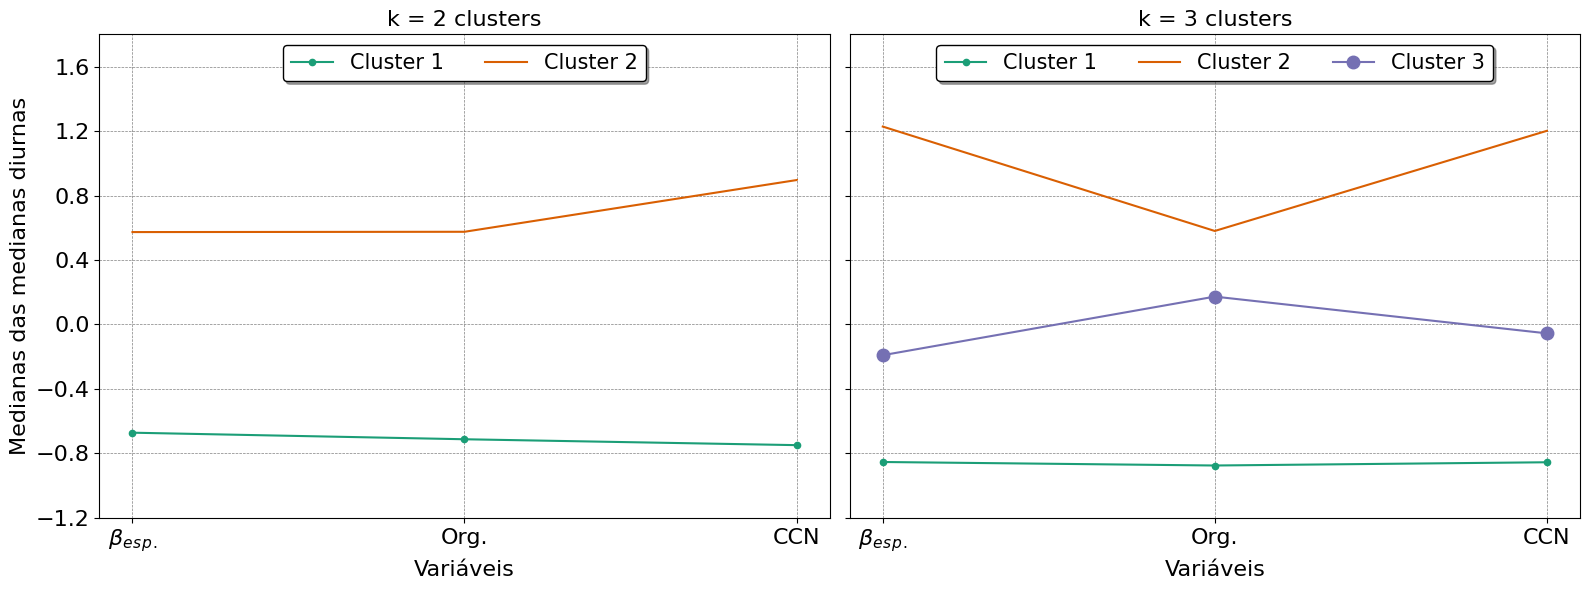

In [72]:
#### Fazendo a figura e os eixos (os "axs"):
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6), facecolor='white')
axes = [axs[0], axs[1]]

### Setando o tamanho da fonte e cores:
tf = 16
for i in range(len(axes)):
    plt.setp(axes[i].get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[i].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
    axes[i].grid(b=True, which='both', axis='both', color='grey', linestyle='--', linewidth=0.5)
    axes[i].set(ylim=[-1.2, 1.8], facecolor='white')
    axes[i].yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    m_styles = markers.MarkerStyle.markers
    colormap = plt.cm.Dark2.colors

    if i == 0:
        axes[i].set_ylabel(u'Medianas das medianas diurnas', fontsize=tf, color='black')
        axes[i].set_xlabel(u'Variáveis', fontsize=tf, color='black')
        axes[i].set_title(u'k = 2 clusters', fontsize=tf, color='black')
        for j, marker, color in zip(range(2),m_styles,colormap):
            axes[i].plot(labels[:-1], medians_k[j], color=color, marker=marker, markersize=9, 
                         label='Cluster '+str(j+1))
        axes[i].legend(loc='upper center', ncol=2, fontsize=tf-1, fancybox='True', shadow='True', 
                       facecolor='white', edgecolor='black')
    if i == 1:
        axes[i].set_xlabel(u'Variáveis', fontsize=tf, color='black')
        axes[i].set_title(u'k = 3 clusters', fontsize=tf, color='black')
        for j, marker, color in zip(range(3),m_styles,colormap):
            axes[i].plot(labels[:-1], medians_k3[j], color=color, marker=marker, markersize=9, 
                         label='Cluster '+str(j+1))
        axes[i].legend(loc='upper center', ncol=3, fontsize=tf-1, fancybox='True', shadow='True', 
                       facecolor='white', edgecolor='black')
#         axes[i].hlines(y=0.0, xmin=0, xmax=2, colors='black', linewidth=0.50)
plt.tight_layout()
plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Clusterização1_2014.png', 
            dpi=400, bbox_inches='tight', facecolor='white')

In [73]:
### Fazendo a clusterização (com K-Means, setando k=3 clusters) dos dados normalizados....
k = 4                  
finaldf_copyk = finaldf.copy()
finaldfnorm_copyk = finaldfnorm.copy()
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=50)
clusters = kmeans.fit_predict(np.array(finaldfnorm))

### Inserindo a coluna 'cluster' no dataframe (cópia) com as medianas diárias diurnas:
finaldf_copyk['cluster'] = clusters

### Inserindo as colunas "dia", "ano" e "cluster" no dataframe (cópia) com os dados normalizados:
finaldfnorm_copyk['dia'] = colunas_interseccao
finaldfnorm_copyk['ano'] = anos
finaldfnorm_copyk['cluster'] = clusters
# finaldfnorm_copyk

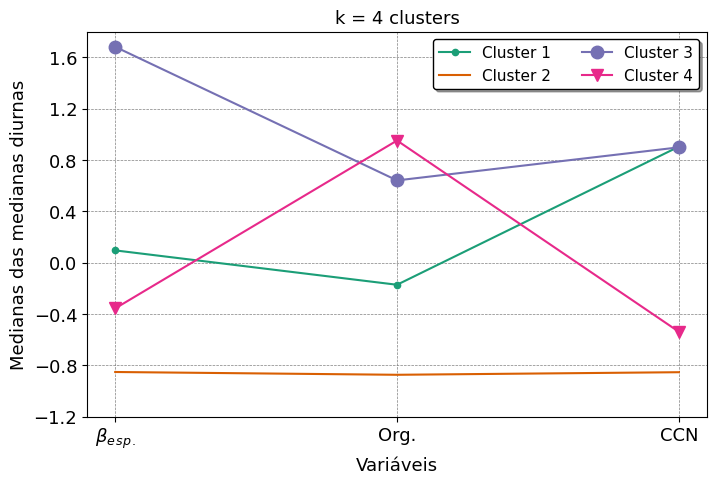

In [74]:
### Selecionando/Filtrando as linhas correspondentes a cada cluster, pegando a mediana normalizada destas linhas
### e guardando na lista "medians_k". Essa lista tem um tamanho igual ao número de clusters, e cada lista 
### interna tem uma mediana normalizada (de medianas diárias diurnas normalizadas) para cada variável:
medians_k = []
for i in range(k):
    medians_k.append(list(finaldfnorm_copyk.loc[finaldfnorm_copyk['cluster']==i].describe().iloc[5,:-1]))

### Gráfico de medianas normalizadas/cluster para ver a tendência das variáveis em cada cluster:
tf=13
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(1,1,1)
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
ax.set_xlabel(u'Variáveis', fontsize=tf, color='black')
ax.set_ylabel('Medianas das medianas diurnas', fontsize=tf, color='black')
ax.set_title('k = 4 clusters', fontsize=tf)
ax.grid(b=True, which='both', axis='both', color='grey', linestyle='--', linewidth=0.5)
ax.set(ylim=[-1.2, 1.8], facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
m_styles = markers.MarkerStyle.markers
colormap = plt.cm.Dark2.colors
for i, marker, color in zip(range(k),m_styles,colormap):
    ax.plot(labels[:-1], medians_k[i], color=color, marker=marker, markersize=9, label='Cluster '+str(i+1))
ax.legend(loc='upper right', ncol=2, fontsize=tf-2, fancybox='True', shadow='True', 
                       facecolor='white', edgecolor='black')

plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Clusterização2_2014.png', 
            dpi=400, bbox_inches='tight', facecolor='white')

In [75]:
### Fazendo a clusterização (com K-Means, setando k=3 clusters) dos dados normalizados....
k = 3                  
finaldf_copyk = finaldf.copy()
finaldfnorm_copyk = finaldfnorm.copy()
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=50)
clusters = kmeans.fit_predict(np.array(finaldfnorm))

### Inserindo a coluna 'cluster' no dataframe (cópia) com as medianas diárias diurnas:
finaldf_copyk['cluster'] = clusters

### Inserindo as colunas "dia", "ano" e "cluster" no dataframe (cópia) com os dados normalizados:
finaldfnorm_copyk['dia'] = colunas_interseccao
finaldfnorm_copyk['ano'] = anos
finaldfnorm_copyk['cluster'] = clusters

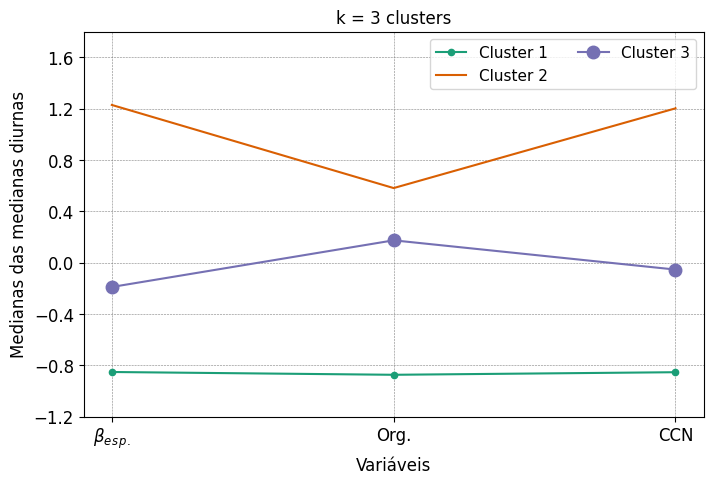

In [76]:
### Selecionando/Filtrando as linhas correspondentes a cada cluster, pegando a mediana normalizada destas linhas
### e guardando na lista "medians_k". Essa lista tem um tamanho igual ao número de clusters, e cada lista 
### interna tem uma mediana normalizada (de medianas diárias diurnas normalizadas) para cada variável:
medians_k = []
for i in range(k):
    medians_k.append(list(finaldfnorm_copyk.loc[finaldfnorm_copyk['cluster']==i].describe().iloc[5,:-1]))

### Gráfico de medianas normalizadas/cluster para ver a tendência das variáveis em cada cluster:
tf=12
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(1,1,1)
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
ax.set_xlabel(u'Variáveis', fontsize=tf, color='black')
ax.set_ylabel('Medianas das medianas diurnas', fontsize=tf, color='black')
ax.set_title('k = {0} clusters'.format(k), fontsize=tf)
ax.grid(b=True, which='both', axis='both', color='grey', linestyle='--', linewidth=0.4)
ax.set(ylim=[-1.2, 1.8], facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
m_styles = markers.MarkerStyle.markers
colormap = plt.cm.Dark2.colors
for i, marker, color in zip(range(k),m_styles,colormap):
    ax.plot(labels[:-1], medians_k[i], color=color, marker=marker, markersize=9, label='Cluster '+str(i+1))
ax.legend(loc='best', fontsize=tf-1, ncols=2)
# ax.hlines(y=0.0, xmin=0, xmax=2, colors='black', linewidth=0.50)

90.07030045052045% da variância total dos dados é mantida quando faço o PCA.


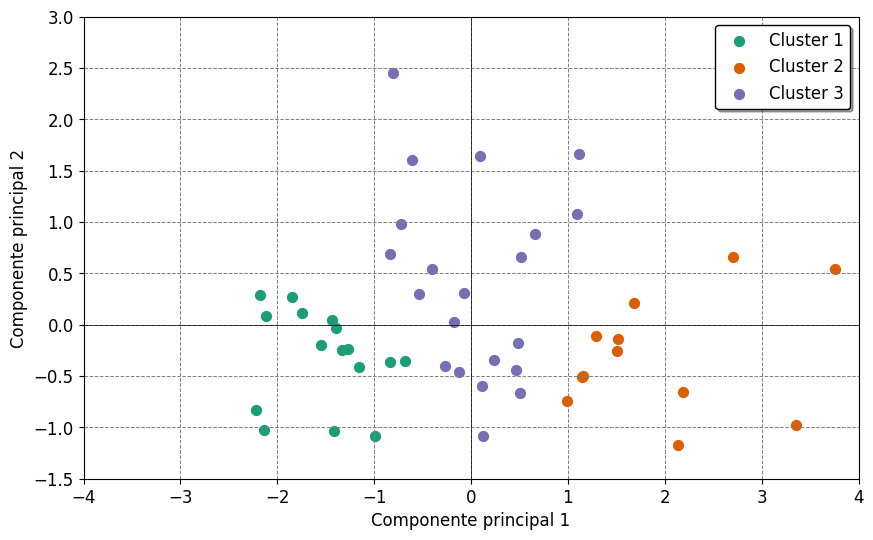

In [77]:
### Fazendo a Análise de Componentes Principais (PCA) a partir do np.array dos dados normalizados:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(arraynorm))
pcaDf = pd.DataFrame(data=principalComponents, columns=['pc_1', 'pc_2'])
variancia_explicada = (pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)
print('{0}% da variância total dos dados é mantida quando faço o PCA.'.format(variancia_explicada))

### Inserindo a coluna 'cluster' no dataframe do PCA para mostrar a qual cluster o componente principal pertence:
pcaDf['cluster'] = clusters
targets = list(range(k))

### Fazendo o gráfico de PCA de acordo com cada cluster:
tf=12
limitesx = [-4, 4]
limitesy = [-1.5, 3]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1) 
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
ax.grid(b=True, which='both', axis='both', color='grey', linestyle='--', linewidth=0.7)
ax.set(xlim=limitesx, ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Componente principal 1', fontsize=tf, color='black')
ax.set_ylabel('Componente principal 2', fontsize=tf, color='black')
# ax.set_title('2-Component PCA Analysis: {0:.2f}% of total data variance is mantained under PCA'.format(variancia_explicada),
#              fontsize=tf, color='black')
colormap = plt.cm.Dark2.colors
for target, color in zip(targets,colormap):
    indicesToKeep = pcaDf['cluster'] == target
    ax.scatter(pcaDf.loc[indicesToKeep,'pc_1'], pcaDf.loc[indicesToKeep,'pc_2'], color=color, s=50,
               label='Cluster '+str(target+1))
ax.legend(loc='best', ncol=1, fontsize=tf, fancybox='True', shadow='True', facecolor='white', edgecolor='black')
# ax.legend(loc='best', fontsize=tf)
ax.hlines(y=0.0, xmin=limitesx[0], xmax=limitesx[1], colors='black', linewidth=0.50)
ax.vlines(x=0.0, ymin=limitesy[0], ymax=limitesy[1], colors='black', linewidth=0.50)
plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/PCA_Clusters_2014.png', dpi=400,
            bbox_inches='tight', facecolor='white')

In [78]:
### Verificando o tamanho de cada cluster para depois vinculá-los às massas de ar:
for i in range(k):
    print('Cluster {0} tem {1} dias/pontos'.format(str(i+1),
                                                   len(finaldf_copyk.loc[finaldf_copyk['cluster']==i])))

Cluster 1 tem 16 dias/pontos
Cluster 2 tem 12 dias/pontos
Cluster 3 tem 21 dias/pontos


In [79]:
### Vinculando cada cluster com uma massa de ar específica e depois inserindo a coluna 'massa' no dataframe
### (cópia) com as medianas diárias diurnas:
massas = ['Cluster 1', 'Cluster 2', 'Cluster 3']
massa = []
for l in range(len(finaldf_copyk)):
    if finaldf_copyk['cluster'][l] == 0:
        massa.append(massas[0])
    elif finaldf_copyk['cluster'][l] == 1:
        massa.append(massas[1])
    elif finaldf_copyk['cluster'][l] == 2:
        massa.append(massas[2])
finaldf_copyk['massa'] = massa
finaldf_copyk

,Bs_550_1,org,ccn,dia,ano,cluster,massa
0,7.955,2.392250,465.550995,08/02/2014,2014,1,Cluster 2
1,6.875,1.815162,499.747162,09/02/2014,2014,1,Cluster 2
2,6.120,1.585082,280.063385,10/02/2014,2014,2,Cluster 3
3,4.900,0.777386,213.196030,11/02/2014,2014,0,Cluster 1
4,5.440,1.587852,411.625488,12/02/2014,2014,2,Cluster 3
5,5.670,1.284691,452.019043,13/02/2014,2014,2,Cluster 3
6,11.870,2.350746,408.582916,14/02/2014,2014,1,Cluster 2
7,9.090,1.727368,268.675537,15/02/2014,2014,2,Cluster 3
8,7.035,1.808527,309.309814,16/02/2014,2014,2,Cluster 3
9,2.980,1.421698,108.241013,17/02/2014,2014,0,Cluster 1


In [90]:
### Pegando os dias de cada massa e colocando eles em uma lista:
dias_fundo = list(finaldf_copyk.loc[finaldf_copyk['massa']==massas[0]]['dia'])
dias_local = list(finaldf_copyk.loc[finaldf_copyk['massa']==massas[2]]['dia'])
dias_pluma = list(finaldf_copyk.loc[finaldf_copyk['massa']==massas[1]]['dia'])

In [91]:
dias_fundo

['11/02/2014',
 '17/02/2014',
 '23/02/2014',
 '24/02/2014',
 '26/02/2014',
 '28/02/2014',
 '02/03/2014',
 '06/03/2014',
 '07/03/2014',
 '08/03/2014',
 '12/03/2014',
 '20/03/2014',
 '21/03/2014',
 '22/03/2014',
 '25/03/2014',
 '28/03/2014']

In [92]:
# datasets14[0][dias_fundo].iloc[periodo_diurno[0]:periodo_diurno[1]]

In [93]:
### Função que lê as colunas dum dataframe e retorna uma lista (cheia!) com os dados das colunas concatenados: 
def dados_concatenados(df):
    lista = []
    for col in df:
        for lin in range(len(df[col])):
            lista.append(df[col].values[lin])
    return lista

In [94]:
### Criando, com os dados de Coef. de Espalhamento, uma lista cheia para cada uma das massas:
Esp_lcheia_fundo = dados_concatenados(datasets14[0][dias_fundo].iloc[periodo_diurno[0]:periodo_diurno[1]])
Esp_lcheia_local = dados_concatenados(datasets14[0][dias_local].iloc[periodo_diurno[0]:periodo_diurno[1]])
Esp_lcheia_pluma = dados_concatenados(datasets14[0][dias_pluma].iloc[periodo_diurno[0]:periodo_diurno[1]])

### Lista com as listas de CN para cada massa:
liEsp = [Esp_lcheia_fundo, Esp_lcheia_local, Esp_lcheia_pluma]

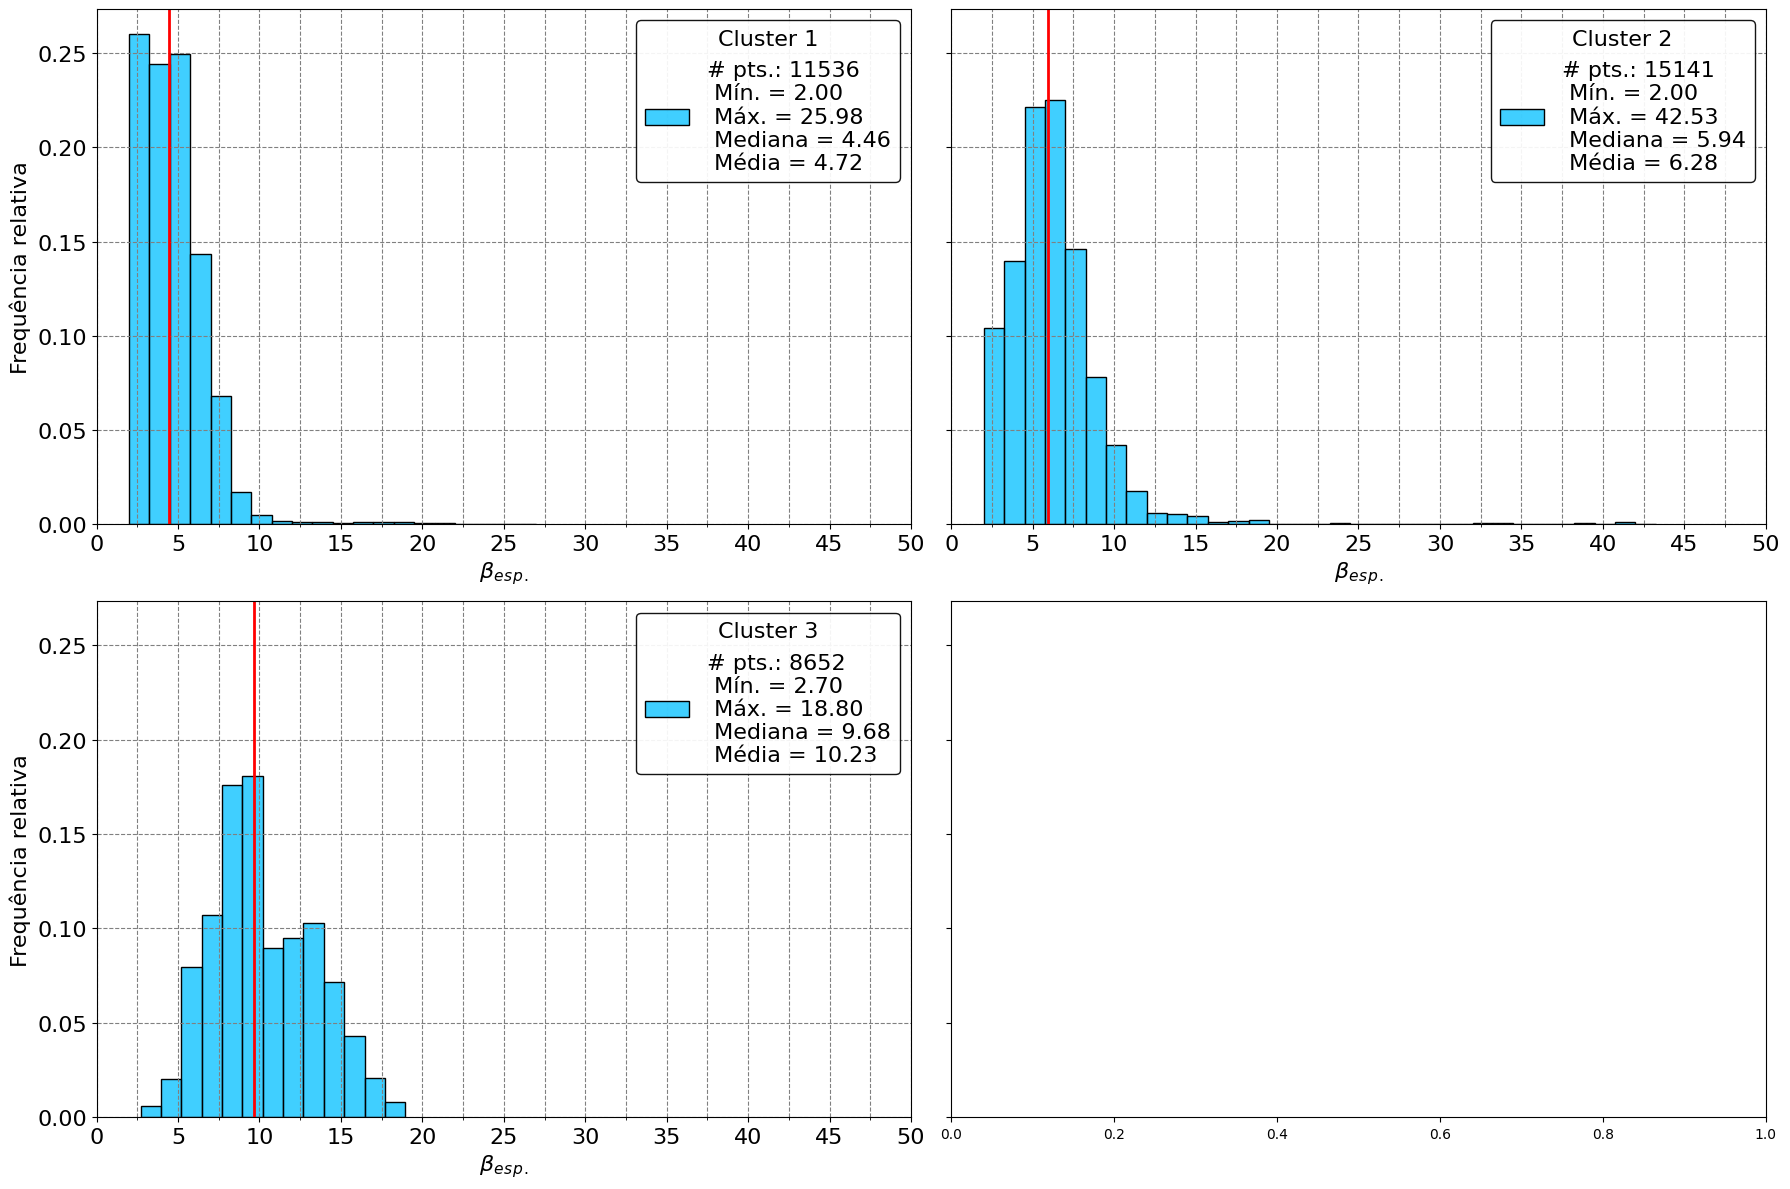

In [97]:
#### Fazendo a figura e os eixos (os "axs"):
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(18, 12), facecolor='white')
axes = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

### Setando o tamanho da fonte e cores:
limx = [0, 50]
ticksx = limx[1]/10
h = ticksx/4
tf = 16
cores = ['deepskyblue', 'red']

for i in range(len(liEsp)):
    lbl = labels[0]
    massa = massas[i]
    dados = liEsp[i]
    ############################### Estatísticas ############################################
    media = np.nanmean(dados)
    p50 = np.nanmedian(dados) 
    dmin = np.nanmin(dados)
    dmax = np.nanmax(dados)
    AT = dmax - dmin
    ############################### Histograma ###############################################
    if i==0:
        axes[i].set_ylabel('Frequência relativa', fontsize=tf, color='black')
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
    elif i==2:
        axes[i].set_ylabel('Frequência relativa', fontsize=tf, color='black')
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
    elif i==1 or i==3:
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
#     elif i==4:
#         axes[i].set_xlabel(lbl, fontsize=tf, color='black')
#         axes[i].set_ylabel('Relative frequency', fontsize=tf, color='black')
#         axes[i].set_ylim([axes[0].get_ylim()[0], axes[0].get_ylim()[1]])
    axes[i].grid(b=True, which='both', axis='both', color='grey', linestyle='--', linewidth=0.8)
    axes[i].set_xlim(limx)
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(ticksx))
    axes[i].xaxis.set_minor_locator(ticker.MultipleLocator(ticksx/2))
    sns.histplot(data=dados, ax=axes[i], binwidth=h, stat='probability', color=cores[0], 
                 edgecolor='black', label='# pts.: {0}\n Mín. = {1:.2f}\n Máx. = {2:.2f}\n Mediana = {3:.2f}\n Média = {4:.2f}'.format(len(dados), dmin, dmax, p50, media))
    axes[i].legend(frameon=True, framealpha=0.92, loc='best', ncol=2, fontsize=tf, fancybox=True,
                   edgecolor='black', title=massa, title_fontsize=tf, shadow=False, facecolor='white')
    plt.setp(axes[i].get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[i].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
    axes[i].axvline(x=p50, color=cores[1], lw=2.0)
plt.tight_layout()

plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Histogramas_Bs_Clusters_2014.png',
            dpi=400, bbox_inches='tight', facecolor='white')

In [98]:
### Criando, com os dados de Org., uma lista cheia para cada uma das massas:
Org_lcheia_fundo = dados_concatenados(datasets14[1][dias_fundo].iloc[periodo_diurno[0]:periodo_diurno[1]])
Org_lcheia_local = dados_concatenados(datasets14[1][dias_local].iloc[periodo_diurno[0]:periodo_diurno[1]])
Org_lcheia_pluma = dados_concatenados(datasets14[1][dias_pluma].iloc[periodo_diurno[0]:periodo_diurno[1]])

### Lista com as listas de CN para cada massa:
liOrg = [Org_lcheia_fundo, Org_lcheia_local, Org_lcheia_pluma]

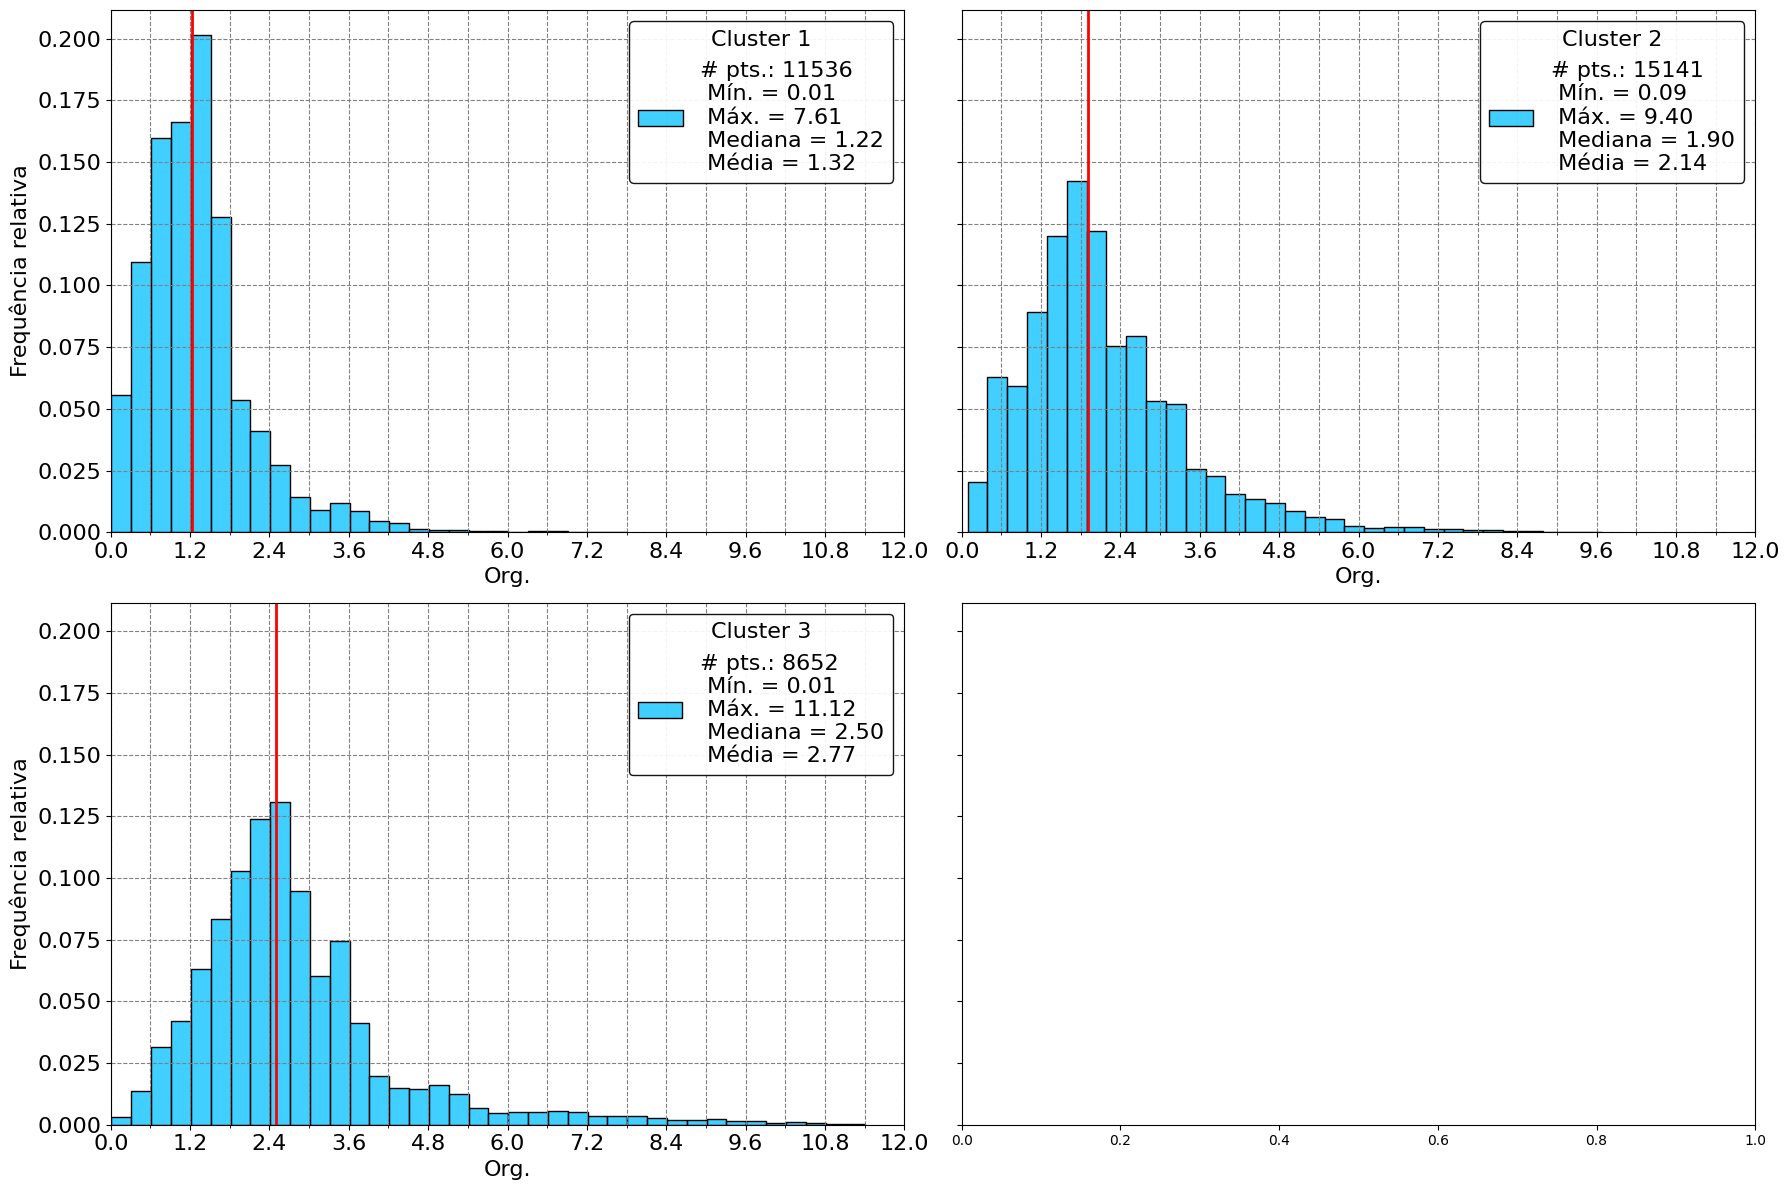

In [101]:
#### Fazendo a figura e os eixos (os "axs"):
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(18, 12), facecolor='white')
axes = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

### Setando o tamanho da fonte e cores:
limx = [0, 12]
ticksx = limx[1]/10
h = ticksx/4
tf = 16
cores = ['deepskyblue', 'red']

for i in range(len(liOrg)):
    lbl = labels[1]
    massa = massas[i]
    dados = liOrg[i]
    ############################### Estatísticas ############################################
    media = np.nanmean(dados)
    p50 = np.nanmedian(dados) 
    dmin = np.nanmin(dados)
    dmax = np.nanmax(dados)
    AT = dmax - dmin
    ############################### Histograma ###############################################
    if i==0:
        axes[i].set_ylabel('Frequência relativa', fontsize=tf, color='black')
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
    elif i==2:
        axes[i].set_ylabel('Frequência relativa', fontsize=tf, color='black')
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
    elif i==1 or i==3:
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
#     elif i==4:
#         axes[i].set_xlabel(lbl, fontsize=tf, color='black')
#         axes[i].set_ylabel('Relative frequency', fontsize=tf, color='black')
#         axes[i].set_ylim([axes[0].get_ylim()[0], axes[0].get_ylim()[1]])
    axes[i].grid(b=True, which='both', axis='both', color='grey', linestyle='--', linewidth=0.8)
    axes[i].set_xlim(limx)
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(ticksx))
    axes[i].xaxis.set_minor_locator(ticker.MultipleLocator(ticksx/2))
    sns.histplot(data=dados, ax=axes[i], binwidth=h, stat='probability', color=cores[0], 
                 edgecolor='black', label='# pts.: {0}\n Mín. = {1:.2f}\n Máx. = {2:.2f}\n Mediana = {3:.2f}\n Média = {4:.2f}'.format(len(dados), dmin, dmax, p50, media))
    axes[i].legend(frameon=True, framealpha=0.92, loc='best', ncol=2, fontsize=tf, fancybox=True,
                   edgecolor='black', title=massa, title_fontsize=tf, shadow=False, facecolor='white')
    plt.setp(axes[i].get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[i].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
    axes[i].axvline(x=p50, color=cores[1], lw=2.0)
plt.tight_layout()

plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Histogramas_Org_Clusters_2014.png',
            dpi=400, bbox_inches='tight', facecolor='white')

In [102]:
### Criando, com os dados de CCN., uma lista cheia para cada uma das massas:
CCN_lcheia_fundo = dados_concatenados(datasets14[2][dias_fundo].iloc[periodo_diurno[0]:periodo_diurno[1]])
CCN_lcheia_local = dados_concatenados(datasets14[2][dias_local].iloc[periodo_diurno[0]:periodo_diurno[1]])
CCN_lcheia_pluma = dados_concatenados(datasets14[2][dias_pluma].iloc[periodo_diurno[0]:periodo_diurno[1]])

### Lista com as listas de CN para cada massa:
liCCN = [CCN_lcheia_fundo, CCN_lcheia_local, CCN_lcheia_pluma]

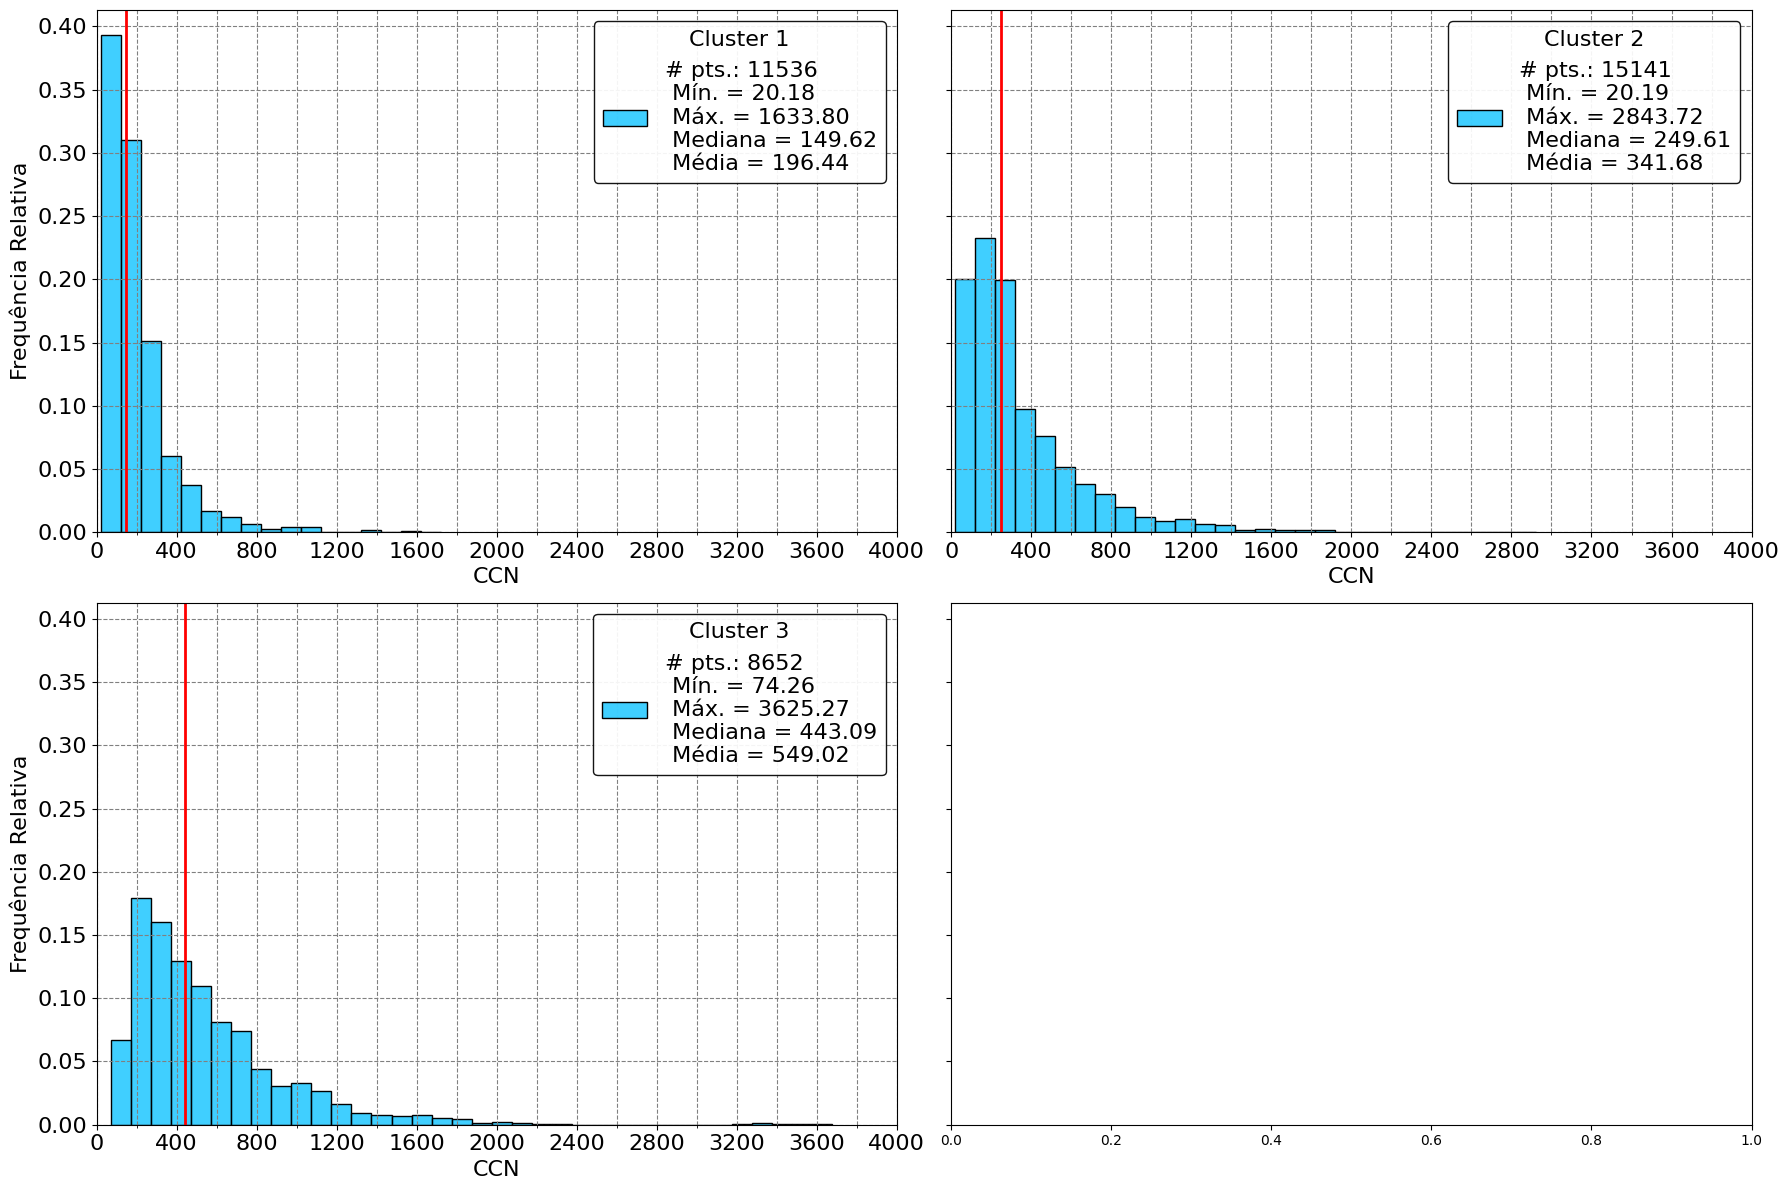

In [103]:
#### Fazendo a figura e os eixos (os "axs"):
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(18, 12), facecolor='white')
axes = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

### Setando o tamanho da fonte e cores:
limx = [0, 4000]
ticksx = limx[1]/10
h = ticksx/4
tf = 16
cores = ['deepskyblue', 'red']

for i in range(len(liCCN)):
    lbl = labels[2]
    massa = massas[i]
    dados = liCCN[i]
    ############################### Estatísticas ############################################
    media = np.nanmean(dados)
    p50 = np.nanmedian(dados) 
    dmin = np.nanmin(dados)
    dmax = np.nanmax(dados)
    AT = dmax - dmin
    ############################### Histograma ###############################################
    if i==0:
        axes[i].set_ylabel('Frequência Relativa', fontsize=tf, color='black')
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
    elif i==2:
        axes[i].set_ylabel('Frequência Relativa', fontsize=tf, color='black')
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
    elif i==1 or i==3:
        axes[i].set_xlabel(lbl, fontsize=tf, color='black')
#     elif i==4:
#         axes[i].set_xlabel(lbl, fontsize=tf, color='black')
#         axes[i].set_ylabel('Relative frequency', fontsize=tf, color='black')
#         axes[i].set_ylim([axes[0].get_ylim()[0], axes[0].get_ylim()[1]])
    axes[i].grid(b=True, which='both', axis='both', color='grey', linestyle='--', linewidth=0.8)
    axes[i].set_xlim(limx)
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(ticksx))
    axes[i].xaxis.set_minor_locator(ticker.MultipleLocator(ticksx/2))
    sns.histplot(data=dados, ax=axes[i], binwidth=h, stat='probability', color=cores[0], 
                 edgecolor='black', label='# pts.: {0}\n Mín. = {1:.2f}\n Máx. = {2:.2f}\n Mediana = {3:.2f}\n Média = {4:.2f}'.format(len(dados), dmin, dmax, p50, media))
    axes[i].legend(frameon=True, framealpha=0.92, loc='best', ncol=2, fontsize=tf, fancybox=True,
                   edgecolor='black', title=massa, title_fontsize=tf, shadow=False, facecolor='white')
    plt.setp(axes[i].get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[i].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
    axes[i].axvline(x=p50, color=cores[1], lw=2.0)
plt.tight_layout()

plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Histogramas_CCN_Clusters_2014.png',
            dpi=400, bbox_inches='tight', facecolor='white')

In [104]:
##############################################

In [105]:
dias_fundo

['11/02/2014',
 '17/02/2014',
 '23/02/2014',
 '24/02/2014',
 '26/02/2014',
 '28/02/2014',
 '02/03/2014',
 '06/03/2014',
 '07/03/2014',
 '08/03/2014',
 '12/03/2014',
 '20/03/2014',
 '21/03/2014',
 '22/03/2014',
 '25/03/2014',
 '28/03/2014']

In [106]:
dias_pluma

['08/02/2014',
 '09/02/2014',
 '14/02/2014',
 '25/02/2014',
 '04/03/2014',
 '09/03/2014',
 '10/03/2014',
 '11/03/2014',
 '14/03/2014',
 '17/03/2014',
 '26/03/2014',
 '29/03/2014']

In [107]:
dias_local

['10/02/2014',
 '12/02/2014',
 '13/02/2014',
 '15/02/2014',
 '16/02/2014',
 '21/02/2014',
 '22/02/2014',
 '27/02/2014',
 '01/03/2014',
 '03/03/2014',
 '05/03/2014',
 '13/03/2014',
 '15/03/2014',
 '16/03/2014',
 '18/03/2014',
 '19/03/2014',
 '23/03/2014',
 '24/03/2014',
 '27/03/2014',
 '30/03/2014',
 '31/03/2014']

In [18]:
####### "dias_fundo" que vem do "Descobrindo_dias_pluma_clusters.ipynb":
dias_fundo = ['11/02/2014', '17/02/2014', '23/02/2014', '24/02/2014', '26/02/2014', '28/02/2014', '02/03/2014',
              '06/03/2014', '07/03/2014', '08/03/2014', '12/03/2014', '20/03/2014', '21/03/2014', '22/03/2014',
              '25/03/2014', '28/03/2014']

dias_fundo_n = [41, 47, 53, 54, 56, 58, 60, 64, 65, 66, 70, 78, 79, 80, 83, 86]

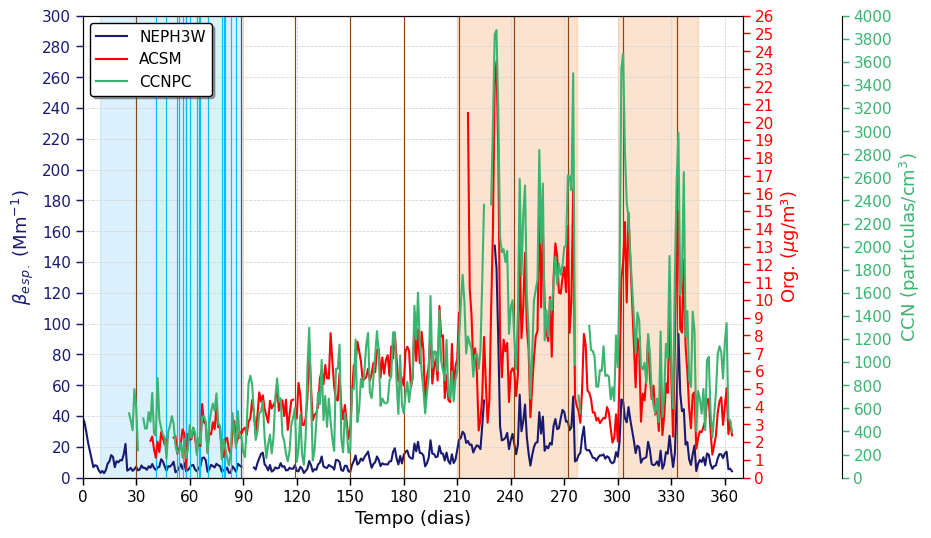

In [19]:
########################################## Configs:
cores = ['midnightblue', 'r', 'mediumseagreen', 'saddlebrown']
limitesx = [0, 370]
limitesy = [0.0, 300.0]
limitesyorg = [0.0, 26]
limitesyccn = [0.0, 4000.0]
tf = 13

########################################## Elimina e acerta posições dos axes:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
fig, host = plt.subplots(figsize=(8,6), facecolor='white')
fig.subplots_adjust(right=0.95)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.15))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

########################################## Setting dos limites, das legendas e plotting de cada variável:
p1, = host.plot(np.arange(len(colunas14)), stats14[0].T['mean'], color=cores[0], label="NEPH3W")
p2, = par1.plot(np.arange(len(colunas14)), stats14[1].T['mean'], color=cores[1], label="ACSM")
p3, = par2.plot(np.arange(len(colunas14)), stats14[2].T['mean'], color=cores[2], label="CCNPC")
host.set_xlim(limitesx)
host.set_ylim(limitesy)
par1.set_ylim(limitesyorg)
par2.set_ylim(limitesyccn)
# host.set_title(u"2014 Daily Means at T3", fontsize=tf)
host.set_xlabel('Tempo (dias)', fontsize=tf)
host.set_ylabel(labels[0]+' (Mm$^{-1}$)', fontsize=tf)
par1.set_ylabel(labels[1]+' ($\mu$g/m³)', fontsize=tf)
par2.set_ylabel(labels[2]+' (partículas/cm$^{3}$)', fontsize=tf)
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
tkw = dict(size=5, width=1.05)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
plt.setp(host.get_xticklabels(), rotation=0, fontsize=tf-2)
plt.setp(host.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par1.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par2.get_yticklabels(), rotation=0, fontsize=tf-2)

host.xaxis.set_major_locator(ticker.MultipleLocator(30))
host.yaxis.set_major_locator(ticker.MultipleLocator(20))
par1.yaxis.set_major_locator(ticker.MultipleLocator(1))
par2.yaxis.set_major_locator(ticker.MultipleLocator(200))

lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines], fontsize=tf-2, loc='upper left', ncol=1, fancybox=True,
            shadow=True, facecolor='white', edgecolor='black')
host.grid(visible=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.55)

### Desenhando linhas verticais delimitando os meses do ano:
for mes, n in zip([0,1,2,3,4,5,6,7,8,9,10],[30,58,89,119,150,180,211,242,272,303,333]):
    host.vlines(x=n, ymin=limitesy[0], ymax=limitesy[1], colors=cores[3], linewidth=0.85)
    
host.axvspan(xmin=10, xmax=90, color='lightskyblue', alpha=0.3)
# host.axvspan(xmin=210, xmax=345, color='sandybrown', alpha=0.3)
host.axvspan(xmin=210, xmax=277, color='sandybrown', alpha=0.3)
host.axvspan(xmin=300, xmax=345, color='sandybrown', alpha=0.3)

##################################################################################################
for j in dias_fundo_n:
    host.vlines(x=j, ymin=limitesy[0], ymax=limitesy[1], colors='deepskyblue', linewidth=0.85)

# plt.show()

plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Series_Cenarios_2014_Final.png', 
            dpi=400, bbox_inches='tight', facecolor='white')